# Model Evaluation: ROC Curve, Confusion Matrix, and Feature Importance
This notebook loads the trained Random Forest model and scaler to visualize model performance and feature importance.

## Section 1: Import Required Libraries

In [2]:
%matplotlib inline

import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

print('[✓] All libraries imported successfully')

[✓] All libraries imported successfully


## Section 2: Load the Scaler and Model

In [3]:
# Define paths
model_dir = os.path.expanduser('~/malware_detection')
model_path = os.path.join(model_dir, 'model_rf.pkl')
scaler_path = os.path.join(model_dir, 'scaler.pkl')

# Load the scaler and model
print(f'[*] Loading scaler from: {scaler_path}')
scaler = joblib.load(scaler_path)
print(f'[✓] Scaler loaded')

print(f'[*] Loading model from: {model_path}')
rf_model = joblib.load(model_path)
print(f'[✓] Model loaded')

# Display model info
print(f'\n[*] Model type: {type(rf_model).__name__}')
print(f'[*] Number of trees: {rf_model.n_estimators}')
print(f'[*] Max depth: {rf_model.max_depth}')

[*] Loading scaler from: /home/ubuntu/malware_detection/scaler.pkl
[✓] Scaler loaded
[*] Loading model from: /home/ubuntu/malware_detection/model_rf.pkl
[✓] Model loaded

[*] Model type: RandomForestClassifier
[*] Number of trees: 100
[*] Max depth: 15


## Section 3: Prepare Test Data

In [4]:
# Load dataset
csv_path = os.path.expanduser('~/malware_detection/dataset/data_with_features.csv')
print(f'[*] Loading data from: {csv_path}')
df = pd.read_csv(csv_path)
print(f'[✓] Loaded {len(df)} samples')

# Prepare features and labels (same as training)
exclude_cols = ['protocol', 'remote_ip', 'local_ip', 'md5_hash', 'sha512_hash', 'data_hex', 'class', 'target']
feature_cols = [col for col in df.columns if col not in exclude_cols and col not in ['target']]

X = df[feature_cols].copy()
y = df['target'].copy()

# Handle NaN values
X = X.fillna(0)

# Split data (same random state as training)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'[*] Training set: {len(X_train)} samples')
print(f'[*] Test set: {len(X_test)} samples')
print(f'[*] Features: {len(feature_cols)}')
print(f'[*] Class distribution (test): {y_test.value_counts().to_dict()}')

# Scale test data using the loaded scaler
print(f'\n[*] Scaling test data...')
X_test_scaled = scaler.transform(X_test)
print(f'[✓] Test data scaled')

[*] Loading data from: /home/ubuntu/malware_detection/dataset/data_with_features.csv
[✓] Loaded 17008 samples
[*] Training set: 13606 samples
[*] Test set: 3402 samples
[*] Features: 44
[*] Class distribution (test): {1.0: 2450, 0.0: 952}

[*] Scaling test data...
[✓] Test data scaled


## Section 4: Generate ROC Curve

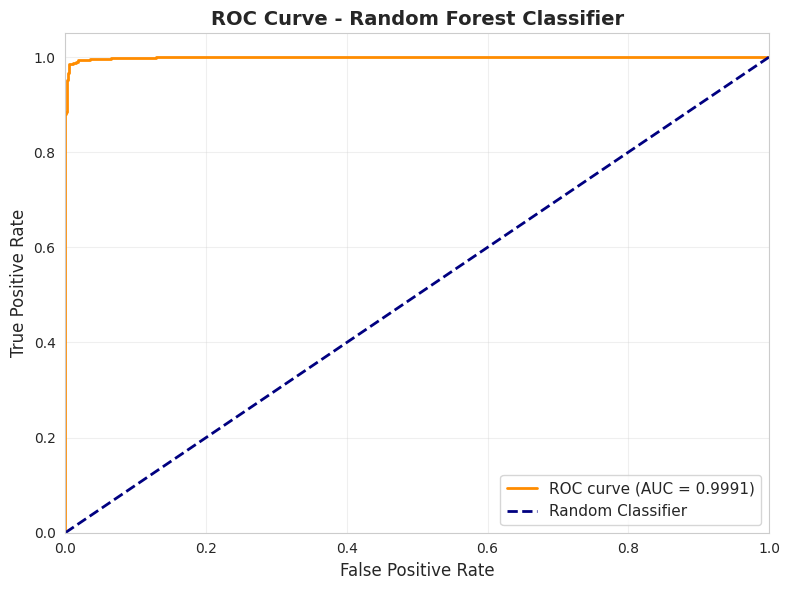


[✓] ROC AUC Score: 0.9991


In [5]:
# Generate predictions and probabilities
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Random Forest Classifier', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'\n[✓] ROC AUC Score: {roc_auc:.4f}')

## Section 5: Create Confusion Matrix

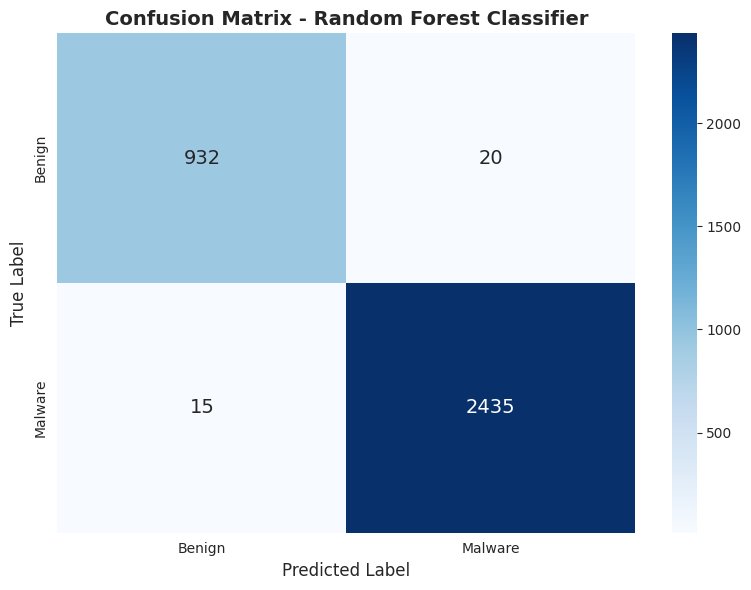


[*] Confusion Matrix Results:
  True Negatives (TN): 932
  False Positives (FP): 20
  False Negatives (FN): 15
  True Positives (TP): 2435

[*] Performance Metrics:
  Sensitivity (Recall): 0.9939
  Specificity: 0.9790
  Precision: 0.9919

[*] Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.98      0.98       952
     Malware       0.99      0.99      0.99      2450

    accuracy                           0.99      3402
   macro avg       0.99      0.99      0.99      3402
weighted avg       0.99      0.99      0.99      3402



In [6]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Benign', 'Malware'],
            yticklabels=['Benign', 'Malware'],
            annot_kws={'size': 14})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Random Forest Classifier', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed metrics
tn, fp, fn, tp = cm.ravel()
print(f'\n[*] Confusion Matrix Results:')
print(f'  True Negatives (TN): {tn}')
print(f'  False Positives (FP): {fp}')
print(f'  False Negatives (FN): {fn}')
print(f'  True Positives (TP): {tp}')

# Calculate additional metrics
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0

print(f'\n[*] Performance Metrics:')
print(f'  Sensitivity (Recall): {sensitivity:.4f}')
print(f'  Specificity: {specificity:.4f}')
print(f'  Precision: {precision:.4f}')

print(f'\n[*] Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware']))

## Section 6: Plot Feature Importance

[*] Feature Importance Results:
                  feature  importance
33            length_log2    0.158995
34         length_squared    0.158708
2                  length    0.156652
32             length_log    0.155651
35            length_sqrt    0.144146
26  remote_ip_first_octet    0.048673
24   remote_ip_last_octet    0.040835
14          md5_digit_sum    0.018674
16       sha512_digit_sum    0.018130
0             remote_port    0.015598
1              local_port    0.014343
28               port_sum    0.013604
30             port_ratio    0.011716
29              port_diff    0.011426
38       length_is_medium    0.009040


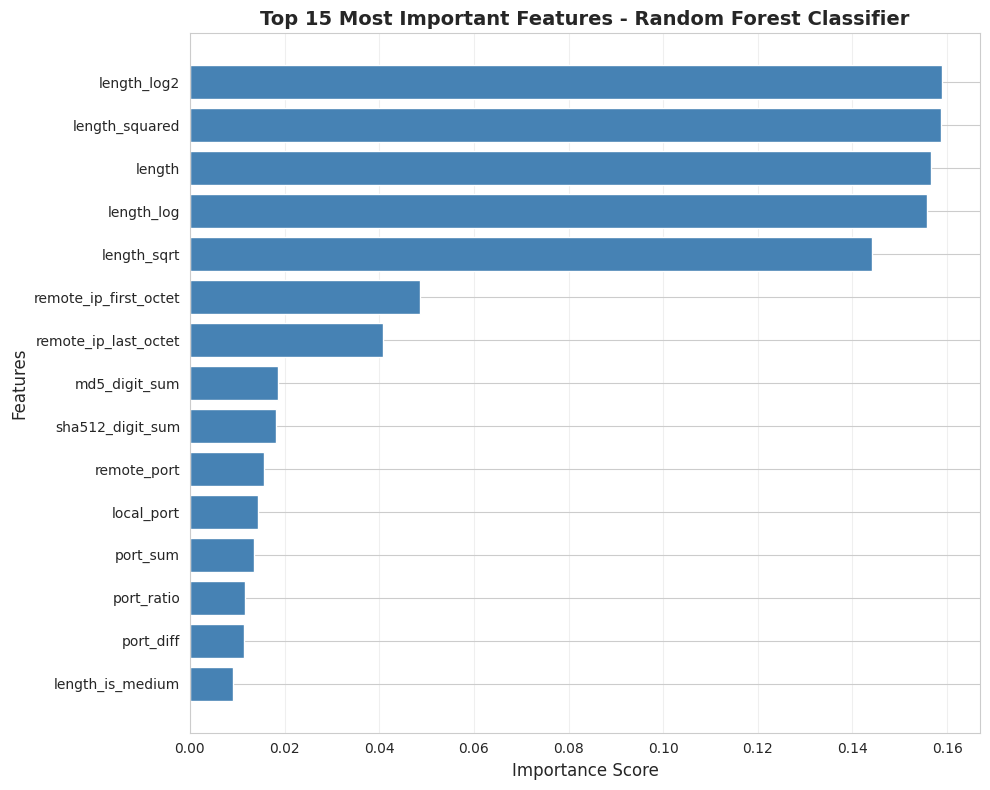


[✓] Total features: 44
[✓] Mean importance: 0.022727
[✓] Max importance: 0.158995
[✓] Top feature: length_log2 (0.158995)


In [7]:
# Extract feature importances
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f'[*] Feature Importance Results:')
print(feature_importance.head(15))

# Plot top 15 features
top_n = 15
top_features = feature_importance.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title(f'Top {top_n} Most Important Features - Random Forest Classifier', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print(f'\n[✓] Total features: {len(feature_cols)}')
print(f'[✓] Mean importance: {feature_importance["importance"].mean():.6f}')
print(f'[✓] Max importance: {feature_importance["importance"].max():.6f}')
print(f'[✓] Top feature: {feature_importance.iloc[0]["feature"]} ({feature_importance.iloc[0]["importance"]:.6f})')

## Summary
This notebook successfully:
1. ✓ Loaded the trained Random Forest model from `model_rf.pkl`
2. ✓ Loaded the StandardScaler from `scaler.pkl`
3. ✓ Generated and visualized the ROC curve with AUC score
4. ✓ Created a confusion matrix heatmap
5. ✓ Displayed feature importance rankings